In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier,plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Load Data

Upload the files to your Google Drive and mount it in the Colab notebook using the code below.

Files: `promos.csv.gz`, `test_history.csv.gz`, `train_history.csv.gz`, and `transactions.csv.gz`.

In [3]:
# This will ask you to give Colab permission to access your Google Drive 
# and enter an authorization code.
# See: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# MODIFY THIS LINE with the path to where you saved the datafiles on your Google drive
path = '/content/drive/MyDrive/ColabNotebooks/8521/Assignment 3'

In [5]:
promos = pd.read_csv(path + '/promos.csv.gz')
promos

,promo,category,promoqty,manufacturer,promoval,brand
0,209524,51006740,1,1593002228,1.00,189092190
1,176321,42760698,1,1957688344,0.75,1386413202
2,17125,56844954,1,629075831,1.50,1429623935
3,177412,56844954,1,629075831,1.50,1429623935
4,69839,56844954,1,629075831,1.50,1429623935
5,73739,56844954,1,629075831,1.50,1429623935
6,97335,56844954,1,629075831,1.50,1429623935
7,37568,75228190,1,1154816776,2.00,1234009542
8,108252,75228190,1,1154816776,2.00,1234009542
9,65353,20487740,1,122801592,1.50,324788825


In [6]:
train_history = pd.read_csv(path + '/train_history.csv.gz', parse_dates=['promodate'])
train_history

,id,store,promo,region,promodate,active
0,115562959531,860548,176321,243820,2013-03-25,0.0
1,175261390705,625933,37568,191747,2013-03-15,0.0
2,273751574633,527828,209524,165933,2013-03-23,1.0
3,166923268906,1056730,214816,5506,2013-03-20,0.0
4,135410903443,241369,176321,278897,2013-03-25,0.0
...,...,...,...,...,...,...
19995,202681208,1137612,170791,296095,2013-03-30,0.0
19996,31947749517,625933,37568,191747,2013-03-24,0.0
19997,221594674995,285434,176321,36431,2013-03-26,0.0
19998,284764722045,927995,176321,243820,2013-03-26,0.0


In [7]:
test_history = pd.read_csv(path + '/test_history.csv.gz', parse_dates=['promodate'])
test_history.head()

,id,store,promo,region,promodate,active
0,250462324156,457755,96852,191747,2013-04-22,NaN
1,61214568335,740794,54956,203586,2013-04-23,NaN
2,274776763999,394092,95011,42773,2013-04-02,NaN
3,91546215019,876095,108237,323706,2013-04-24,NaN
4,220718580189,625933,222088,191747,2013-04-18,NaN


In [8]:
transactions = pd.read_csv(path + '/transactions.csv.gz', parse_dates=['date'])
transactions.head()

,id,store,market_group,category,manufacturer,brand,date,productsize,measure,qty,amt
0,31924309471,96431,360548,10881580,707582354,109487351,2012-03-06,28.00,OZ,1,2.69
1,31924309471,96431,80472,75959720,2052533430,254982935,2012-03-06,12.00,OZ,2,8.48
2,31924309471,96431,194893,80209099,1640770606,1252530761,2012-03-06,6.00,OZ,1,1.69
3,31924309471,96431,27828,10942974,946555356,2133681340,2012-03-06,0.75,LT,1,11.41
4,31924309471,96431,135933,64737859,700393013,221618334,2012-03-06,33.84,OZ,1,3.19


#Data Exploration

In [9]:
#Have we seen the promotions before?
unique_train_promos=train_history.promo.unique()
unique_test_promos=test_history.promo.unique()
print ("Number of Unique Training Promos:",len(unique_train_promos))
print ("Number of Unique Testing Promos:",len(unique_test_promos))
print("Number of Promos in Common:",len(set(unique_train_promos).intersection(unique_test_promos)))

Number of Unique Training Promos: 15
Number of Unique Testing Promos: 17
Number of Promos in Common: 8


We have only seen half of the promotions before! Meaning it will be quite difficult to use previous promotion data to predict future promotion data for half

In [12]:
#Do we know the customer?
unique_train_cust=train_history.id.unique()
unique_test_cust=test_history.id.unique()
print ("Number of Unique Training Customers:",len(unique_train_cust))
print ("Number of Unique Testing Customers:",len(unique_test_cust))
print("Number of Customers in Common:",len(set(unique_train_cust).intersection(unique_test_cust)))

Number of Unique Training Customers: 20000
Number of Unique Testing Customers: 10000
Number of Customers in Common: 0


Not a single customer repeats in the training and test dataset meaning we would need lots of features to detect similar customers

In [11]:
#train_history['DayofWeek']= train_history['promodate'].dt.day_name()
#train_history['DayofWeek'].value_counts(normalize=True)

Monday       0.18495
Wednesday    0.17905
Tuesday      0.15990
Saturday     0.15070
Friday       0.14095
Thursday     0.11725
Sunday       0.06720
Name: DayofWeek, dtype: float64

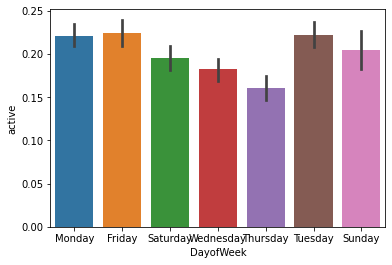

In [12]:
#sns.barplot(data=train_history,x='DayofWeek',y='active')

The bar chart aboves highlights the average activity based on day of the week


In [15]:
#train_history=train_history.drop('DayofWeek', axis=1)

In [16]:
#transactions['DayofWeek']= transactions['date'].dt.day_name()
#transactions['DayofWeek'].value_counts(normalize=True)

#Buffer Implementation (Training)

To prevent data leakage, we must implement a buffer period into this propensity model. Thus, a time based training and validation (prediction) set will be developed and used to predict a blind test set

In [9]:
train_history.promodate.min()

Timestamp('2013-03-01 00:00:00')

In [10]:
train_history.promodate.max()

Timestamp('2013-03-31 00:00:00')

In [11]:
test_history.promodate.min()

Timestamp('2013-04-01 00:00:00')

In [12]:
test_history.promodate.max()

Timestamp('2013-04-30 00:00:00')

In [13]:
transactions.date.min()

Timestamp('2012-03-02 00:00:00')

In [14]:
transactions.date.max()

Timestamp('2013-02-28 00:00:00')

In [15]:
train_transactions= transactions.loc[transactions.date <= '2013-01-31',:].sort_values(by='date',ascending = False)

11 months of transaction data will be used to predict month of promos with a buffer of 1 month better 
2012-03-02 --> 2013-01-31 of transactions followed by one month buffer to predict 2013-03-01 to 2013-03-31 of promos 

# Extract Features

# Mean & standard deviation of the difference between purchases in days

In [16]:
#https://towardsdatascience.com/predicting-next-purchase-day-15fae5548027


order_df = train_transactions[['id','date']]
order_df = order_df.sort_values(['id','date'])
order_df = order_df.drop_duplicates(subset=['id','date'],keep='first')
order_df

,id,date
17046881,32159355,2012-03-07
17046883,32159355,2012-03-13
17046897,32159355,2012-03-25
17046921,32159355,2012-03-26
17046928,32159355,2012-03-30
...,...,...
16894238,299868458280,2012-11-16
16894241,299868458280,2012-11-21
16894247,299868458280,2012-11-25
16894250,299868458280,2012-12-07


In [17]:
#shifting last purchase day
order_df['first'] = order_df.groupby('id')['date'].shift(1)
order_df

,id,date,first
17046881,32159355,2012-03-07,NaT
17046883,32159355,2012-03-13,2012-03-07
17046897,32159355,2012-03-25,2012-03-13
17046921,32159355,2012-03-26,2012-03-25
17046928,32159355,2012-03-30,2012-03-26
...,...,...,...
16894238,299868458280,2012-11-16,2012-10-19
16894241,299868458280,2012-11-21,2012-11-16
16894247,299868458280,2012-11-25,2012-11-21
16894250,299868458280,2012-12-07,2012-11-25


In [18]:
order_df['Diff1'] = (order_df['date'] - order_df['first']).dt.days

In [19]:
order_df_diff = order_df.groupby('id').agg({'Diff1': ['mean','std']}).reset_index()
order_df_diff.columns = ['id', 'Diff1Mean','Diff1Std']
order_df_diff

,id,Diff1Mean,Diff1Std
0,32159355,4.787879,3.353598
1,38085541,6.795918,5.499923
2,41697872,4.217949,2.656271
3,54676900,4.230769,2.652727
4,58631253,4.086420,3.302263
...,...,...,...
29948,299808438838,2.737705,1.893020
29949,299820408183,3.681818,2.714565
29950,299831899601,3.719101,3.441025
29951,299863577990,5.610169,4.234574


# Compute RFM Features by Category





In [20]:
max_date = train_transactions.date.max()
train_transactions['last_purchase'] = (max_date - train_transactions['date']) / np.timedelta64(1, "D")

# Agg transaction data to id
trans_features = train_transactions.groupby(['category','id']).agg({
    'last_purchase': 'min',
    'date': ['nunique', 'min'],
    'amt': 'sum',
})

# Compute RFM columns
trans_features['category_recency'] = trans_features['last_purchase']['min']
trans_features['category_frequency'] = (trans_features['date']['nunique']
                               / ((max_date - trans_features['date']['min']) / np.timedelta64(1, "D")))
trans_features['category_monetary'] = trans_features['amt']['sum']

# Select out required features
trans_features = trans_features[['category_recency', 'category_frequency', 'category_monetary']].reset_index()
trans_features.columns = trans_features.columns.get_level_values(0)
trans_features

,category,id,category_recency,category_frequency,category_monetary
0,25087,54676900,0.0,0.052083,-13.19
1,25087,58631253,3.0,0.188192,2.19
2,25087,67203160,95.0,0.034483,63.25
3,25087,74224170,11.0,0.072727,27.68
4,25087,77651817,4.0,0.093190,4.89
...,...,...,...,...,...
5427042,82780461,299691276069,138.0,0.008982,20.48
5427043,82780461,299705530987,80.0,0.014493,11.97
5427044,82780461,299780866426,182.0,0.005495,6.67
5427045,82780461,299787920532,234.0,0.004274,2.49


In [21]:
trans_features.describe()

,category,id,category_recency,category_frequency,category_monetary
count,5.427047e+06,5.427047e+06,5.427047e+06,5.427047e+06,5.427047e+06
mean,4.298520e+07,1.501067e+11,1.053419e+02,inf,3.164867e+01
std,2.465540e+07,8.654414e+10,9.372612e+01,NaN,1.668497e+03
min,2.508700e+04,3.215936e+07,0.000000e+00,2.985075e-03,-2.157514e+04
25%,2.070029e+07,7.470352e+10,2.600000e+01,6.849315e-03,3.490000e+00
50%,4.468305e+07,1.503001e+11,7.500000e+01,1.282051e-02,7.500000e+00
75%,6.566642e+07,2.247002e+11,1.690000e+02,2.464789e-02,1.871000e+01
max,8.278046e+07,2.998685e+11,3.350000e+02,inf,1.800012e+06


In [22]:
#replace infinity values due to denominator dividing by 0 because they shop daily
trans_features= trans_features.replace(np.inf,1)

# Compute RFM Features by Brand


In [23]:
max_date = train_transactions.date.max()
train_transactions['last_purchase'] = (max_date - train_transactions['date']) / np.timedelta64(1, "D")

# Agg transaction data to id
trans_features_brand = train_transactions.groupby(['brand','id']).agg({
    'last_purchase': 'min',
    'date': ['nunique', 'min'],
    'amt': 'sum',
})

# Compute RFM columns
trans_features_brand['brand_recency'] = trans_features_brand['last_purchase']['min']
trans_features_brand['brand_frequency'] = (trans_features_brand['date']['nunique']
                               / ((max_date - trans_features_brand['date']['min']) / np.timedelta64(1, "D")))
trans_features_brand['brand_monetary'] = trans_features_brand['amt']['sum']

# Select out required features
trans_features_brand = trans_features_brand[['brand_recency', 'brand_frequency', 'brand_monetary']].reset_index()
trans_features_brand.columns = trans_features_brand.columns.get_level_values(0)
trans_features_brand

,brand,id,brand_recency,brand_frequency,brand_monetary
0,186028,120573534764,12.0,0.083333,4.29
1,186028,163919615662,47.0,0.024096,18.75
2,186028,297919529670,231.0,0.004329,3.89
3,188229,1401169960,110.0,0.009091,12.98
4,188229,4232624595,87.0,0.011494,6.93
...,...,...,...,...,...
6356837,2417180595,234488507710,134.0,0.007463,4.39
6356838,2417180595,273967823194,95.0,0.010526,4.09
6356839,2417189971,66637769375,77.0,0.012987,2.49
6356840,2417189971,70413083458,309.0,0.003236,2.49


In [24]:
#replace infinity values due to denominator dividing by 0 because they shop daily
trans_features_brand= trans_features_brand.replace(np.inf,1)

# Generate Customer Features

In [25]:
#looking at the number of unique categories, brands, total number of units purchased and dollar amount sum for all customers
customerdf= train_transactions.groupby('id',as_index=False).agg({
    'category':'nunique',
    'brand':'nunique',
    'qty':'sum',
    'amt':'sum'
})

In [26]:
customerdf.rename({'brand':'unique_brands', 'category':'unique_categories'}, axis=1, inplace=True)
customerdf['Average_Spending']=customerdf['amt']/customerdf['qty']

In [27]:
customerdf

,id,unique_categories,unique_brands,qty,amt,Average_Spending
0,32159355,220,251,731,2923.16,3.998851
1,38085541,151,166,666,2021.31,3.035000
2,41697872,236,305,1541,4527.18,2.937820
3,54676900,105,103,745,1598.92,2.146201
4,58631253,233,263,1266,4445.84,3.511722
...,...,...,...,...,...,...
29948,299808438838,173,192,1046,3220.54,3.078910
29949,299820408183,216,260,1268,2965.46,2.338691
29950,299831899601,300,374,2340,5766.68,2.464393
29951,299863577990,175,192,821,2580.08,3.142607


#Day of the Week Impact

In [23]:
train_history['DayofWeek']= train_history['promodate'].dt.day_name()
train_history=pd.get_dummies(train_history)
train_history

,id,store,promo,region,promodate,active,DayofWeek_Friday,DayofWeek_Monday,DayofWeek_Saturday,DayofWeek_Sunday,DayofWeek_Thursday,DayofWeek_Tuesday,DayofWeek_Wednesday
0,115562959531,860548,176321,243820,2013-03-25,0.0,0,1,0,0,0,0,0
1,175261390705,625933,37568,191747,2013-03-15,0.0,1,0,0,0,0,0,0
2,273751574633,527828,209524,165933,2013-03-23,1.0,0,0,1,0,0,0,0
3,166923268906,1056730,214816,5506,2013-03-20,0.0,0,0,0,0,0,0,1
4,135410903443,241369,176321,278897,2013-03-25,0.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,202681208,1137612,170791,296095,2013-03-30,0.0,0,0,1,0,0,0,0
19996,31947749517,625933,37568,191747,2013-03-24,0.0,0,0,0,1,0,0,0
19997,221594674995,285434,176321,36431,2013-03-26,0.0,0,0,0,0,0,1,0
19998,284764722045,927995,176321,243820,2013-03-26,0.0,0,0,0,0,0,1,0


In [24]:
test_history['DayofWeek']= test_history['promodate'].dt.day_name()
test_history=pd.get_dummies(test_history)
test_history

,id,store,promo,region,promodate,active,DayofWeek_Friday,DayofWeek_Monday,DayofWeek_Saturday,DayofWeek_Sunday,DayofWeek_Thursday,DayofWeek_Tuesday,DayofWeek_Wednesday
0,250462324156,457755,96852,191747,2013-04-22,NaN,0,1,0,0,0,0,0
1,61214568335,740794,54956,203586,2013-04-23,NaN,0,0,0,0,0,1,0
2,274776763999,394092,95011,42773,2013-04-02,NaN,0,0,0,0,0,1,0
3,91546215019,876095,108237,323706,2013-04-24,NaN,0,0,0,0,0,0,1
4,220718580189,625933,222088,191747,2013-04-18,NaN,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,100789336581,476177,54956,293974,2013-04-24,NaN,0,0,0,0,0,0,1
9996,159975443931,1137612,54956,296095,2013-04-26,NaN,1,0,0,0,0,0,0
9997,204493309111,405412,170791,296095,2013-04-01,NaN,0,1,0,0,0,0,0
9998,52802927357,625933,176321,191747,2013-04-17,NaN,0,0,0,0,0,0,1


# Generate train, test and prediction sets

In [28]:
# Generate train/test features
features= train_history.merge(promos,on='promo',how='left')
features = features.merge(trans_features, on=['category','id'], how='left')
features= features.merge(trans_features_brand, on=['brand','id'],how='left')
features= features.merge(customerdf,on='id',how='left')
features = features.merge(order_df_diff,on='id',how='left')

features.category_recency.fillna(365, inplace=True)
features.category_frequency.fillna(0, inplace=True)
features.category_monetary.fillna(0, inplace=True)
features.Diff1Mean.fillna(0, inplace=True)
features.Diff1Std.fillna(0, inplace=True)
features.brand_recency.fillna(365, inplace=True)
features.brand_frequency.fillna(0, inplace=True)
features.brand_monetary.fillna(0, inplace=True)

features.unique_categories.fillna(0, inplace=True)
features.unique_brands.fillna(0, inplace=True)
features.Average_Spending.fillna(0, inplace=True)



x_cols = ['category_recency', 'category_frequency', 'category_monetary','brand_recency','brand_frequency','brand_monetary','Diff1Mean','Diff1Std','unique_categories','unique_brands','Average_Spending','promoval']
y_col = 'active'

X = features[x_cols]
y = features[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [29]:
# Generate prediction features (for blind test)
predict_features= test_history.merge(promos,on='promo',how='left')
predict_features = predict_features.merge(trans_features, on=['category','id'], how='left')
predict_features= predict_features.merge(trans_features_brand, on=['brand','id'],how='left')
predict_features= predict_features.merge(customerdf,on='id',how='left')
predict_features = predict_features.merge(order_df_diff,on='id',how='left')

predict_features.category_recency.fillna(365, inplace=True)
predict_features.category_frequency.fillna(0, inplace=True)
predict_features.category_monetary.fillna(0, inplace=True)
predict_features.Diff1Mean.fillna(0, inplace=True)
predict_features.Diff1Std.fillna(0, inplace=True)
predict_features.brand_recency.fillna(365, inplace=True)
predict_features.brand_frequency.fillna(0, inplace=True)
predict_features.brand_monetary.fillna(0, inplace=True)
predict_features.unique_categories.fillna(0, inplace=True)
predict_features.unique_brands.fillna(0, inplace=True)
predict_features.Average_Spending.fillna(0, inplace=True)

X_predict = predict_features[x_cols]
predict_out = predict_features[['id', 'active']].copy()

#Correlation Plot

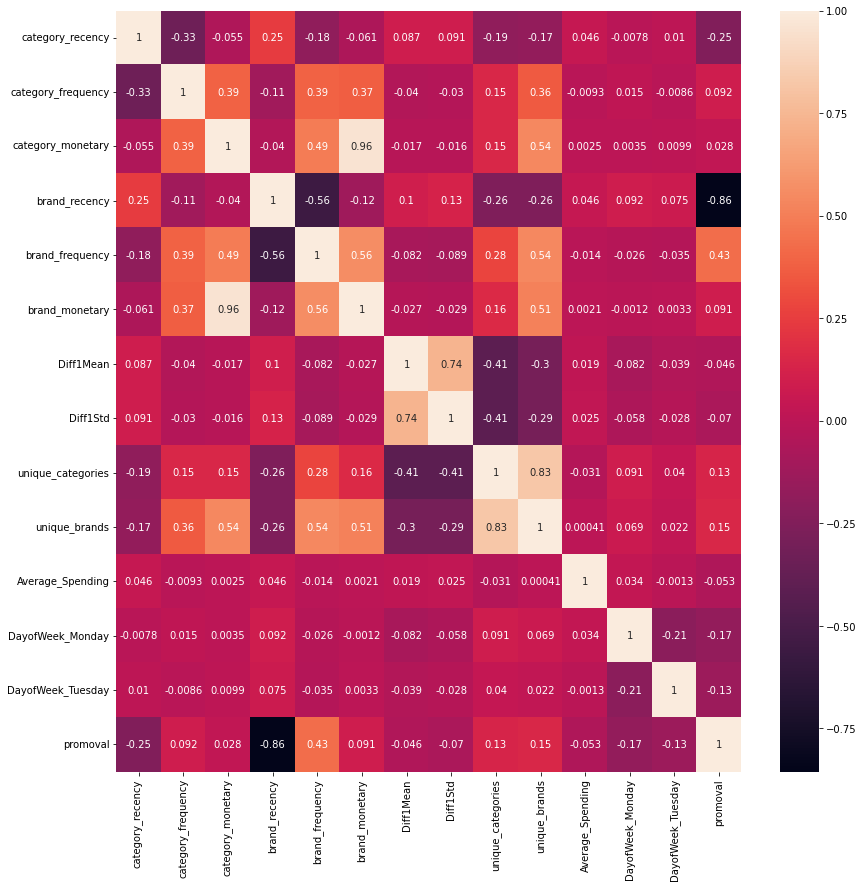

In [38]:
plt.figure(figsize = (14,14))
sns.heatmap(X.corr(),annot=True)

correlation looks better then anticipated, only 2 pairs that highly correlated that will be dealt with during feature selection

# Build Model: Random Forest (Not Used)

In [40]:
#model = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=42)
#model.fit(X_train, y_train)

In [41]:
#print('Test Accuracy: {:.2f}'.format(model.score(X_test, y_test)))
#print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

#Hyper Parameter Tuning

In [45]:
#https://stackoverflow.com/questions/68539280/how-to-optimize-xgboost code used to cross validate
#create a dictionary of all values we want to test
#param_grid = { 'max_depth': [4,5,6] , 'min_child_weight':[4,5,6] ,'learning_rate': [0.05,0.1,0.5] ,'n_estimators': [20,50,100],'eval_metric':['error']}
# decision tree model
#boost=XGBClassifier()
#use gridsearch to test all values
#boost = GridSearchCV(boost, param_grid, )
#fit model to data
#boost.fit(X_train, y_train)
#print(boost.best_params_)
#print(boost.best_estimator_)
#print(boost.best_score_)


{'eval_metric': 'error', 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50}
XGBClassifier(eval_metric='error', learning_rate=0.05, max_depth=5,
              min_child_weight=5, n_estimators=50)
0.8023125


#Build Model: XGBoost

In [56]:
boost=XGBClassifier(eval_metric='auc',learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=5)
boost.fit(X_train,y_train)

print('Test accuracy: {:.2f}'.format(boost.score(X_test, y_test)))
print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, boost.predict_proba(X_test)[:, 1])))

Test accuracy: 0.81
Test AUC: 0.69


In [61]:
boost.feature_importances_

array([0.21401806, 0.0736973 , 0.08490894, 0.02261436, 0.01342652,
       0.0290118 , 0.00759575, 0.01580267, 0.0344548 , 0.04678496,
       0.02183653, 0.        , 0.        , 0.43584833], dtype=float32)

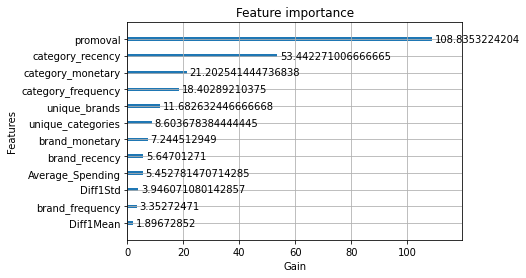

In [59]:
plot_importance(boost, importance_type = 'gain', xlabel='Gain')

In [30]:
boost=XGBClassifier(eval_metric='auc',learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=5)
boost.fit(X,y)

XGBClassifier(eval_metric='auc', learning_rate=0.05, max_depth=5,
              min_child_weight=5, n_estimators=5)

In [31]:
del train_history
del train_transactions
gc.collect()

122

#Regenerate Features for Test Set

In [32]:
test_transactions = transactions.loc[transactions.date >= '2012-04-01',:].sort_values(by='date',ascending = False)

Mean & standard deviation of the difference between purchases in days

In [33]:
#https://towardsdatascience.com/predicting-next-purchase-day-15fae5548027


order_df = test_transactions[['id','date']]
order_df = order_df.sort_values(['id','date'])
order_df = order_df.drop_duplicates(subset=['id','date'],keep='first')
order_df

,id,date
17046936,32159355,2012-04-02
17046944,32159355,2012-04-11
17046952,32159355,2012-04-14
17046965,32159355,2012-04-18
17046968,32159355,2012-04-21
...,...,...
16894259,299868458280,2012-12-23
16894266,299868458280,2013-02-02
16894270,299868458280,2013-02-08
16894271,299868458280,2013-02-13


In [34]:
#shifting last purchase day
order_df['first'] = order_df.groupby('id')['date'].shift(1)
order_df

,id,date,first
17046936,32159355,2012-04-02,NaT
17046944,32159355,2012-04-11,2012-04-02
17046952,32159355,2012-04-14,2012-04-11
17046965,32159355,2012-04-18,2012-04-14
17046968,32159355,2012-04-21,2012-04-18
...,...,...,...
16894259,299868458280,2012-12-23,2012-12-07
16894266,299868458280,2013-02-02,2012-12-23
16894270,299868458280,2013-02-08,2013-02-02
16894271,299868458280,2013-02-13,2013-02-08


In [35]:
order_df['Diff1'] = (order_df['date'] - order_df['first']).dt.days

In [36]:
order_df_diff = order_df.groupby('id').agg({'Diff1': ['mean','std']}).reset_index()
order_df_diff.columns = ['id', 'Diff1Mean','Diff1Std']
order_df_diff

,id,Diff1Mean,Diff1Std
0,32159355,5.061538,3.836001
1,38085541,6.812500,5.362027
2,41697872,4.049383,2.696763
3,54676900,4.024390,2.591418
4,58631253,4.000000,3.123475
...,...,...,...
29983,299808438838,2.813559,1.880849
29984,299820408183,3.696629,2.681606
29985,299831899601,3.781609,3.435198
29986,299863577990,5.724138,4.187672


Compute RFM Features by Category





In [37]:
max_date = test_transactions.date.max()
test_transactions['last_purchase'] = (max_date - test_transactions['date']) / np.timedelta64(1, "D")

# Agg transaction data to id
trans_features = test_transactions.groupby(['category','id']).agg({
    'last_purchase': 'min',
    'date': ['nunique', 'min'],
    'amt': 'sum',
})

# Compute RFM columns
trans_features['category_recency'] = trans_features['last_purchase']['min']
trans_features['category_frequency'] = (trans_features['date']['nunique']
                               / ((max_date - trans_features['date']['min']) / np.timedelta64(1, "D")))
trans_features['category_monetary'] = trans_features['amt']['sum']

# Select out required features
trans_features = trans_features[['category_recency', 'category_frequency', 'category_monetary']].reset_index()
trans_features.columns = trans_features.columns.get_level_values(0)
trans_features

,category,id,category_recency,category_frequency,category_monetary
0,25087,54676900,17.0,0.054545,-9.44
1,25087,58631253,0.0,0.200669,2.19
2,25087,67203160,123.0,0.037175,62.26
3,25087,74224170,25.0,0.067358,30.17
4,25087,77651817,5.0,0.094463,4.89
...,...,...,...,...,...
5452438,82780461,299691276069,166.0,0.006689,8.48
5452439,82780461,299705530987,108.0,0.012766,11.97
5452440,82780461,299780866426,210.0,0.004762,6.67
5452441,82780461,299787920532,262.0,0.003817,2.49


In [38]:
trans_features.describe()

,category,id,category_recency,category_frequency,category_monetary
count,5.452443e+06,5.452443e+06,5.452443e+06,5.452443e+06,5.452443e+06
mean,4.299469e+07,1.501146e+11,1.054713e+02,inf,3.129991e+01
std,2.466192e+07,8.654449e+10,9.273510e+01,NaN,1.612932e+03
min,2.508700e+04,3.215936e+07,0.000000e+00,3.003003e-03,-2.199085e+04
25%,2.070029e+07,7.471899e+10,2.600000e+01,6.896552e-03,3.490000e+00
50%,4.468305e+07,1.503001e+11,7.600000e+01,1.277955e-02,7.500000e+00
75%,6.566642e+07,2.247122e+11,1.680000e+02,2.439024e-02,1.866000e+01
max,8.278046e+07,2.998685e+11,3.330000e+02,inf,1.614462e+06


In [39]:
#replace infinity values due to denominator dividing by 0 because they shop daily
trans_features= trans_features.replace(np.inf,1)

Compute RFM Features by Brand


In [40]:
max_date = test_transactions.date.max()
test_transactions['last_purchase'] = (max_date - test_transactions['date']) / np.timedelta64(1, "D")

# Agg transaction data to id
trans_features_brand = test_transactions.groupby(['brand','id']).agg({
    'last_purchase': 'min',
    'date': ['nunique', 'min'],
    'amt': 'sum',
})

# Compute RFM columns
trans_features_brand['brand_recency'] = trans_features_brand['last_purchase']['min']
trans_features_brand['brand_frequency'] = (trans_features_brand['date']['nunique']
                               / ((max_date - trans_features_brand['date']['min']) / np.timedelta64(1, "D")))
trans_features_brand['brand_monetary'] = trans_features_brand['amt']['sum']

# Select out required features
trans_features_brand = trans_features_brand[['brand_recency', 'brand_frequency', 'brand_monetary']].reset_index()
trans_features_brand.columns = trans_features_brand.columns.get_level_values(0)
trans_features_brand

,brand,id,brand_recency,brand_frequency,brand_monetary
0,186028,120573534764,40.0,0.025000,4.29
1,186028,140538383445,19.0,0.052632,5.79
2,186028,163919615662,75.0,0.020619,18.75
3,186028,297919529670,259.0,0.003861,3.89
4,188229,1401169960,138.0,0.007246,12.98
...,...,...,...,...,...
6383365,2417180595,234488507710,162.0,0.006173,4.39
6383366,2417180595,273967823194,123.0,0.008130,4.09
6383367,2417180595,289103024896,13.0,0.076923,4.79
6383368,2417189971,66637769375,105.0,0.009524,2.49


In [41]:
#replace infinity values due to denominator dividing by 0 because they shop daily
trans_features_brand= trans_features_brand.replace(np.inf,1)

Generate Customer Features

In [42]:
#looking at the number of unique categories, brands, total number of units purchased and dollar amount sum for all customers
customerdf= test_transactions.groupby('id',as_index=False).agg({
    'category':'nunique',
    'brand':'nunique',
    'qty':'sum',
    'amt':'sum'
})

In [43]:
customerdf.rename({'brand':'unique_brands', 'category':'unique_categories'}, axis=1, inplace=True)
customerdf['Average_Spending']=customerdf['amt']/customerdf['qty']

In [44]:
customerdf

,id,unique_categories,unique_brands,qty,amt,Average_Spending
0,32159355,215,246,707,2874.38,4.065601
1,38085541,149,163,666,2025.90,3.041892
2,41697872,229,291,1525,4451.30,2.918885
3,54676900,108,107,799,1709.75,2.139862
4,58631253,241,277,1351,4688.00,3.470022
...,...,...,...,...,...,...
29983,299808438838,170,190,1011,3111.30,3.077448
29984,299820408183,217,263,1277,2891.66,2.264417
29985,299831899601,303,386,2427,5690.13,2.344512
29986,299863577990,175,190,852,2606.11,3.058815


Day of the Week Impact

In [45]:
test_history['DayofWeek']= test_history['promodate'].dt.day_name()
test_history=pd.get_dummies(test_history)
test_history

,id,store,promo,region,promodate,active,DayofWeek_Friday,DayofWeek_Monday,DayofWeek_Saturday,DayofWeek_Sunday,DayofWeek_Thursday,DayofWeek_Tuesday,DayofWeek_Wednesday
0,250462324156,457755,96852,191747,2013-04-22,NaN,0,1,0,0,0,0,0
1,61214568335,740794,54956,203586,2013-04-23,NaN,0,0,0,0,0,1,0
2,274776763999,394092,95011,42773,2013-04-02,NaN,0,0,0,0,0,1,0
3,91546215019,876095,108237,323706,2013-04-24,NaN,0,0,0,0,0,0,1
4,220718580189,625933,222088,191747,2013-04-18,NaN,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,100789336581,476177,54956,293974,2013-04-24,NaN,0,0,0,0,0,0,1
9996,159975443931,1137612,54956,296095,2013-04-26,NaN,1,0,0,0,0,0,0
9997,204493309111,405412,170791,296095,2013-04-01,NaN,0,1,0,0,0,0,0
9998,52802927357,625933,176321,191747,2013-04-17,NaN,0,0,0,0,0,0,1


Generate train, test and prediction sets

In [46]:
# Generate prediction features (for blind test)
predict_features= test_history.merge(promos,on='promo',how='left')
predict_features = predict_features.merge(trans_features, on=['category','id'], how='left')
predict_features= predict_features.merge(trans_features_brand, on=['brand','id'],how='left')
predict_features= predict_features.merge(customerdf,on='id',how='left')
predict_features = predict_features.merge(order_df_diff,on='id',how='left')

predict_features.category_recency.fillna(365, inplace=True)
predict_features.category_frequency.fillna(0, inplace=True)
predict_features.category_monetary.fillna(0, inplace=True)
predict_features.Diff1Mean.fillna(0, inplace=True)
predict_features.Diff1Std.fillna(0, inplace=True)
predict_features.brand_recency.fillna(365, inplace=True)
predict_features.brand_frequency.fillna(0, inplace=True)
predict_features.brand_monetary.fillna(0, inplace=True)
predict_features.unique_categories.fillna(0, inplace=True)
predict_features.unique_brands.fillna(0, inplace=True)
predict_features.Average_Spending.fillna(0, inplace=True)

x_cols = ['category_recency', 'category_frequency', 'category_monetary','brand_recency','brand_frequency','brand_monetary','Diff1Mean','Diff1Std','unique_categories','unique_brands','Average_Spending','promoval']
y_col = 'active'

X_predict = predict_features[x_cols]

In [47]:
X_predict

,category_recency,category_frequency,category_monetary,brand_recency,brand_frequency,brand_monetary,Diff1Mean,Diff1Std,unique_categories,unique_brands,Average_Spending,promoval
0,5.0,0.037037,34.77,365.0,0.000000,0.00,3.254902,1.639163,292.0,358.0,3.173472,1.00
1,365.0,0.000000,0.00,365.0,0.000000,0.00,1.549296,0.803097,141.0,139.0,2.414902,2.00
2,28.0,0.031128,20.34,365.0,0.000000,0.00,2.876106,2.636057,139.0,150.0,3.562900,1.00
3,365.0,0.000000,0.00,13.0,0.021341,26.84,3.619565,2.655463,201.0,251.0,2.558285,1.00
4,107.0,0.009346,3.49,365.0,0.000000,0.00,2.401460,1.856863,244.0,304.0,2.027277,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,365.0,0.000000,0.00,365.0,0.000000,0.00,3.431579,2.668383,211.0,213.0,1.989132,2.00
9996,365.0,0.000000,0.00,35.0,0.008696,6.28,12.913043,7.792263,134.0,141.0,5.254651,2.00
9997,148.0,0.010152,8.69,197.0,0.005076,3.13,27.100000,13.118689,67.0,76.0,5.514644,1.25
9998,365.0,0.000000,0.00,365.0,0.000000,0.00,7.357143,6.860354,66.0,79.0,3.381878,0.75


# Generate Prediction

In [48]:
predict_out.head()

,id,active
0,250462324156,NaN
1,61214568335,NaN
2,274776763999,NaN
3,91546215019,NaN
4,220718580189,NaN


In [49]:
predict_out['active'] = boost.predict_proba(X_predict)[:, 1]
predict_out.head()

,id,active
0,250462324156,0.523911
1,61214568335,0.404097
2,274776763999,0.523911
3,91546215019,0.485329
4,220718580189,0.419204


In [50]:
predict_out.to_csv('predict.csv', header=True, index=False)
predict_out.head()

,id,active
0,250462324156,0.523911
1,61214568335,0.404097
2,274776763999,0.523911
3,91546215019,0.485329
4,220718580189,0.419204


In [51]:
# This will download your prediction files
from google.colab import files
files.download('predict.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>